CART 树

基尼系数

与前面介绍的决策树不同，CART 树为二叉树，其划分是基于基尼系数（Gini Index）进行。

先来看看基尼值

![](_images/1.png)

上式从直观上反应了从数据集中任取2个样本，其类别不一致的概率，其值越小，纯度越高。

基尼系数

![](_images/2.png)

划分方式

离散值

也许你已经发现，CART 树在对离散值做划分的时候，若该特征只有两个属性值，那很容易，一边一种就好，但是当属性值大于等于 3 的时候呢？比如 ['青年', '中年', '老年']，这时候应该如何做划分？当然是把所有的方式都遍历一遍啦，存在以下三种情况 [(('青年'), ('中年', '老年')), (('中年'), ('青年', '老年')), (('老年'), ('中年', '青年'))]。到这里我想到了这几个问题：

1. 在做数据挖掘竞赛时，大佬们常说做交叉特征能够帮助决策树更好地做划分，是不是因为这种划分方式的原因。

2. 这种划分方式是不是有些不太适合具有高基数类别变量的数据？所以有些时候采用对这些变量做 count 等统计特征的时候也会有较大的提升

连续值

之前介绍的都是离散值的处理，那么，当遇到连续值的时候，CART 树又是怎么处理的呢？因为是二叉树，所以肯定是选取一个值，大于这个值的分到一个节点中去，小于的分到另一节点中。

那么，这里就涉及到具体的操作了，一般会在划分时先将这一列特征值进行排序，如果有 N 个样本，那么最多会有 N - 1 种情况，从头到尾遍历，每次选择两个值的中点作为划分点，然后计算基尼系数，最后选择值最小的做划分。

如果你关注算法复杂度的话，会发现 CART 树每次做划分的时候都需要遍历所有情况，速度就会很慢。在 XGBoost 和 LightGBM 中，好像是采用了策略对这一计算进行了加速（挖个坑，后面看 XGBoost 和 LightGBM 的时候补上）。

CART 回归树

用 CART 来做分类问题相信有了 C4.5 与 ID3 的基础，再加上面的介绍，肯定也很容易就知道怎么做了。这里我来讲讲如何用 CART 树来做回归问题。

思考一个问题，树模型并不像线性模型那样，可以算出一个 y 值，那么我们如何确定每个叶子节点的预测值呢？在数学上，回归树可以看作一个分段函数，每个叶子节点确定一个分段区间，叶子节点的输出为函数在该节点上的值，且该值为一个定值。

假设 CART 树 T 将特征空间划分为 |T| 个区域 $R_i$ ，并且在每个区域对应的值为 $b_i$ ，对应的假设函数为

![](_images/3.png)

那么，问题在这里就变成了如何划分区域 $Ri$ 和如何确定每个区域 $Ri$ 上对应的值 $bi$ 。

假设区域 $Ri$ 已知，那我们可以使用最小平方损失![](_images/4.png) ，来求对应的 $Bj$ ，显然有 ![](_images/5.png)。

为了划分区域，可采用启发式的方法，选择第 $u$ 个属性和对应的值 $v$ ，作为划分属性和划分阈值，定义两个区域 ![](_images/6.png) ，然后通过求解下式寻找最优的划分属性和划分阈值

![](_images/7.png)

再对两个区域重复上述划分，直到满足条件停止。
实现

下面又到了愉快的代码时间，这里我只写了分类的情况，回归树只需将里面使用的基尼系数改成上面最小化的式子即可。

实现

下面又到了愉快的代码时间，这里我只写了分类的情况，回归树只需将里面使用的基尼系数改成上面最小化的式子即可。

In [2]:
from sklearn.datasets import load_iris
iris=load_iris()   

In [17]:
#可视化树
'''
Created on Oct 14, 2010
@author: Peter Harrington
'''
import matplotlib.pyplot as plt

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

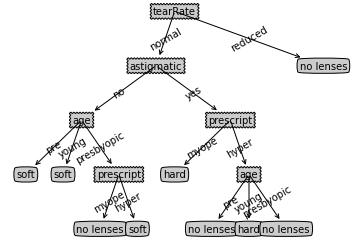

no lenses


"\n#测试数据\ndef createDataSet():\n    dataSet = [[1, 1, 'yes'],\n               [1, 1, 'yes'],\n               [1, 0, 'no'],\n               [0, 1, 'no'],\n               [0, 1, 'no']]\n    labels = ['no surfacing','flippers']\n    #change to discrete values\n    return dataSet, labels\n\ndata,feature_names = createDataSet()\ntree = createTree(data, feature_names)\nprint(classify(tree, feature_names,[1,0]))\n"

In [19]:
from math import *
import operator
import pickle

#计算熵
def entropy(data):
    num = len(data)
    num_labels ={}
    for vec in data:
        num_labels[vec[-1]] = num_labels.get(vec[-1],0)+1
    ent = 0.0
    for key in num_labels.keys():
        prob = float(num_labels[key])/num
        ent -= prob*log(prob,2)
    return ent

#根据给定特征划分数据集, axis是特征对应的编号，value是匹配的值
def splitDataSet(data, axis, value):
    res = []
    for vec in data:
        if vec[axis] == value:
            res.append(vec[:axis] + vec[axis+1:])
    return res

#遍历数据集，计算每种特征对应的信息增益，选出增益最小的，该特征即为用于分类的特征
def chooseFeature(data):
    num_feature = len(data[0])-1
    #计算H(D)
    base_ent = entropy(data)
    max_gain = 0.0
    best_feature = 0
    for i in range(num_feature):
        #找出feature的种类
        uniqueFeature = set([vec[i] for vec in data])
        #对每个feature计算其对应的条件信息熵
        sub_ent = 0.0
        for feature in uniqueFeature:
            sub_data = splitDataSet(data, i, feature)
            prob = len(sub_data)/float(len(data))
            sub_ent += prob*entropy(sub_data)
        #计算每个feature对应的信息增益
        gain = base_ent - sub_ent
        #选择最大的信息增益，其对应的feature即为最佳的feature
        if gain > max_gain:
            max_gain = gain
            best_feature = i
    return best_feature
            
#递归构建决策树
#原始数据集-> 递归地基于最好的属性划分数据集->终止条件：所有属性已经用过或划分后的数据集每个集合只属于一个label,
#若所有属性用完但是每个划分属性不都属于一个label，就使用“多数表决”的方法。

#多数表决函数
def majority(classes):
    classCount = {}
    for item in classes:
        classCount[item] = classCount.get(item,0) + 1
    sortedClassesCount = sorted(classCount.items(), key = operator.itemgetter(1), reverse=True)
    #返回表决最多的label
    return sortedClassCount[0][0]

#递归构建树，存入字典中，以便随后的可视化.feature_name是feature的名字，仅是为了可视化方便。
def createTree(data, feature_names):
    #找出data数据集中所有的labels
    classList = [item[-1] for item in data]
    #如果只属于一种label，则停止构建树
    if len(set(classList)) == 1:
        return classList[0]
    #若果所有features属性都已经使用完，也停止构建树
    #每次用完一个特征都会删除，这样最后数据集data中只剩下最后一位的label位
    if len(data[0]) == 1:
        return majority(classList)
    bestFeat = chooseFeature(data)
    bestFeatName = feature_names[bestFeat]
    #bestFeatName是用于分离数据集的特征的名字，作为根
    tree = {bestFeatName:{}}
    #del只删除元素，但是原来的index不变
    sub_names = feature_names[:]
    del(sub_names[bestFeat])
    uniqFeats = set([item[bestFeat] for item in data])
    #对于每个feature，递归地构建树
    for feature in uniqFeats:
        tree[bestFeatName][feature] = createTree(splitDataSet(data,bestFeat,feature), sub_names)
    return tree
    

#分类函数,也是递归地分类（从根到叶节点）
def classify(tree, feature_names, test_data):
    #找到根，即第一个用于分类的特征
    root = list(tree.keys())[0]
    #找到根对应的子树
    sub_trees = tree[root]
    #找出对应该特征的index
    feat_index = feature_names.index(root)
    #对所有子树，将测试样本划分到属于其的子树
    for key in sub_trees.keys():
        if test_data[feat_index] == key:
            #检查是否还有子树，或者已经到达叶节点
            if type(sub_trees[key]).__name__ == 'dict':
                #若还可以再分，则继续向下找
                return classify(sub_trees[key], feature_names,test_data)
            else:
                #否则直接返回分的类
                return sub_trees[key]

#存储树（存储模型）
def stroeTree(tree, filename):
    fw = open(filename,'w')
    pickle.dump(tree,fw)
    fw.close()
    return
   
#提取树
def grabTree(filename):
    fr = open(filename)
    return pickle.load(fr)

#预测隐形眼镜类型，已知数据集，如何判断患者需要佩戴的眼镜类型
fr = open('lenses.txt')
lenses = [line.strip().split('\t') for line in fr.readlines()]
feature_names = ['age', 'prescript','astigmatic','tearRate']
#构建树
tree = createTree(lenses,feature_names)
#可视化树
createPlot(tree)
#测试
print(classify(tree,feature_names,['pre','myope','no','reduced']))
'''
#测试数据
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    #change to discrete values
    return dataSet, labels

data,feature_names = createDataSet()
tree = createTree(data, feature_names)
print(classify(tree, feature_names,[1,0]))
'''

In [16]:
#sklearn 决策树实现
from sklearn import tree

def DT(train_data, test_data, train_class):
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(train_data, train_class)
    return clf.predict(test_data)
    
fr = open('lenses.txt')
lenses = [line.strip().split('\t') for line in fr.readlines()]
#将class的label从源数据集中分离
train_data = []
train_class = []
for lense in lenses:
    train_data.append(lense[:len(lense)-1])
    train_class.append(lense[-1])
test_data = [['pre','myope','no','reduced']]
#将string的特征和class标签转化为int型
unique_feature = set()
unique_label = set()
for data in train_data:
    for i in range(len(data)):
        unique_feature.add(data[i])
for i in range(len(train_class)):
    unique_label.add(train_class[i])
unique_feature = list(unique_feature)
unique_label = list(unique_label)
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        train_data[i][j] = unique_feature.index(train_data[i][j])
for i in range(len(train_class)):
    train_class[i] = unique_label.index(train_class[i])
for i in range(len(test_data)):
    for j in range(len(test_data[i])):
        test_data[i][j] = unique_feature.index(test_data[i][j])
    
    
print(unique_label[DT(train_data,test_data,train_class)[0]])

no lenses
